# Physics-Informed Neural Networks (PINNs) in JAX

A PINN is a **coordinate network** that attempts to approximate the solution to a
partial differential equation $\hat{u}_\theta(t, x) \approx u(t, x)$. The parameters of
the network $\theta^*$ are found by minimizing the following composite loss 
$$
\theta^* = \arg\min_\theta \mathcal{L}(\theta) = \arg\min_\theta \left( \mathcal{L}_\text{PDE}(\theta) + \mathcal{L}_\text{BC}(\theta) \right)
$$
where $\mathcal{L}_\text{PDE}(\theta)$ is the residual of the differential equation and
$\mathcal{L}_\text{BC}(\theta)$ is the residual of the boundary conditions. In transient
problems, the residual of the initial conditions is also added to the loss.
Derivative information is obtained via higher-order automatic
differentiation of the neural network. In particular, to train PINNs to solve PDEs with the highest
derivative order being $k$, we need $k+1$ autodiff passes (i.e. applications of the
`grad` operator in jax).

Typical architectures for PINNs are Multi-Layer Perceptrons, whose inputs are the
spatial locations $x$ and time $t$ (if applicable). The output of the network is the
solution $\hat{u}_\theta(t, x)$. 

## Example: 1D Poisson equation

In this simple example we train a PINN in Flax to solve the 1D Poisson equation with homogeneous Dirichlet boundary conditions on the unit interval:
$$
\begin{align}
    \frac{d^2 u}{d x^2} &= - f(x), \quad x \in (0, 1) \\
    u(0) &= u(1) = 0
\end{align}
$$
where the source term is given by
$$
f(x) = \begin{cases}
    1 & \text{if } x > 0.3 \land x < 0.5 \\
    0 & \text{otherwise}
\end{cases}

The terms of the loss function to minimize to train the PINN are given by
$$
\mathcal{L}_\text{PDE}(\theta) = \frac{1}{2N} \sum_{i=1}^{N} \left( \frac{d^2
\hat{u}_\theta}{d x^2}\bigg|_{x=x^{[i]}} + f(x^{[i]}) \right)^2
\qquad \text{with} \qquad
x^{[i]} \sim \mathcal{U}(0, 1)
$$
$$
\mathcal{L}_\text{BC}(\theta) = \frac{1}{2} \left( \hat{u}_\theta(0) - 0 \right)^2 + \frac{1}{2} \left( \hat{u}_\theta(1) - 0 \right)^2.
$$

### A reference solution by Finite Differences

To check whether the network is able to learn an accurate solution to the PDE, we use a three-point stencil reference solution.

1. Discretize the unit interval into $N+2$ points, but only consider $N$ interior points.
2. Solve the linear system of equations $A u = b$ with $A \in \mathbb{R}^{N \times N}$ and $b \in \mathbb{R}^N$ with
    1. $A$ being due to the three point-stencil (tri-diagonal matrix with $1$ on the off-diagonals and $-2$ on the diagonal, scaled by $\frac{1}{(\Delta x)^2}$)
    2. $b$ being the right-hand side of the PDE evaluated at the interior points, i.e., $b_i = - f(x_i)$
3. Append (pre/post) the boundary conditions to the solution vector $u$ and plot the solution.

In [409]:
import jax
import jax.numpy as jnp
from jax import random
import numpy as np
from flax import nnx
import optax
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # progress bar
import logging

In [410]:
num_nodes = 100
N_COLLOCATION_POINTS = 50
LEARNING_RATE = 1e-3
N_OPTIMIZATION_EPOCHS = 10_000
BC_LOSS_WEIGHT = 100.0

In [411]:
mesh_full = jnp.linspace(0.0, 1.0, num_nodes + 2)
mesh_interior = mesh_full[1:-1]

In [412]:
rhs_function = lambda x: jnp.where((x > 0.3) & (x < 0.5), 1.0, 0.0)
rhs_evaluated = rhs_function(mesh_interior)

In [413]:
dx = mesh_interior[1] - mesh_interior[0]
A = jnp.diag(jnp.ones(num_nodes - 1), -1) + jnp.diag(jnp.ones(num_nodes - 1), 1) - jnp.diag(2 * jnp.ones(num_nodes), 0)
A /= dx**2

In [414]:
finite_difference_solution = jnp.linalg.solve(A, -rhs_evaluated)

In [415]:
wrap_bc = lambda u: jnp.pad(u, (1, 1), mode="constant")

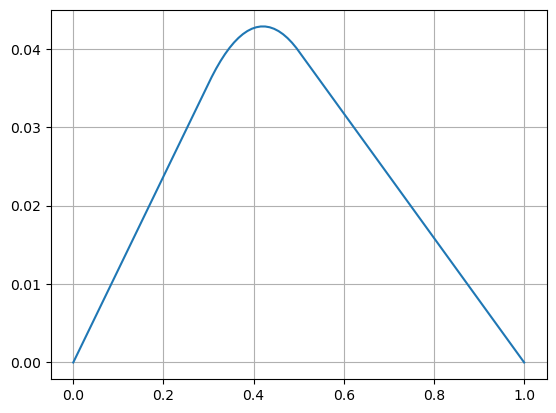

In [416]:
plt.plot(mesh_full, wrap_bc(finite_difference_solution), label="Finite Difference solution")
plt.grid()
plt.show()

### PINN solution

In [417]:
def pde_residual(model, x):
    return jax.grad(jax.grad(model))(x) + rhs_function(x)

In [418]:
class Model(nnx.Module):
  def __init__(self, din, dout, rngs: nnx.Rngs):
    self.linear1 = nnx.Linear(din, 10, rngs=rngs)
    self.linear2 = nnx.Linear(10, 10, rngs=rngs)
    self.linear3 = nnx.Linear(10, 10, rngs=rngs)
    self.linear4 = nnx.Linear(10, dout, rngs=rngs)

  def __call__(self, x):
    x = x[None]
    y = self.linear1(x)
    y = nnx.sigmoid(y)
    y = self.linear2(y)
    y = nnx.sigmoid(y)
    y = self.linear3(y)
    y = nnx.sigmoid(y)
    y = self.linear4(y)
    return y.squeeze()

In [419]:
key = random.key(42)
collocation_points = random.uniform(key, (N_COLLOCATION_POINTS, ), minval=0.0 + 0.001, maxval=1.0 - 0.001)

@nnx.jit
def loss_fn(model, x):
    pde_residual_at_collocation_points = jax.vmap(pde_residual, in_axes=(None, 0))(model, x)
    pde_loss_contribution = 0.5 * jnp.mean(jnp.square(pde_residual_at_collocation_points))

    left_bc_residual = model(jnp.array([0.0])) - 0.0
    right_bc_residual = model(jnp.array([1.0])) - 0.0
    bc_residual_contribution = 0.5 * jnp.mean(jnp.square(left_bc_residual)) + 0.5 * jnp.mean(jnp.square(right_bc_residual))

    total_loss = pde_loss_contribution + BC_LOSS_WEIGHT * bc_residual_contribution

    return total_loss

#### Auxiliary functions

In [420]:
# Train for a single epoch
@nnx.jit
def train_step(model, optimizer, x):
    loss, grads = nnx.value_and_grad(loss_fn)(model, x)
    optimizer.update(grads)
    return loss

def _train_epoch(
    model, optimizer, xs_train, batch_size, rng
):
    train_ds_size = len(xs_train)
    steps_per_epoch = train_ds_size // batch_size

    perms = random.permutation(rng, len(xs_train))
    perms = perms[: steps_per_epoch * batch_size]
    perms = perms.reshape((steps_per_epoch, batch_size))

    epoch_loss = []

    for perm in perms:
        batch_xs = xs_train[perm]
        loss = train_step(model, optimizer, batch_xs)
        epoch_loss.append(loss)  # store training loss for the current batch

    train_loss = np.mean(epoch_loss)
    return model, train_loss


def train(model, optimizer, xs_train, 
          batch_size,epochs, log_period_epoch=1, show_progress=True):

    train_loss_history = []

    for epoch in tqdm(range(1, epochs + 1), disable=not show_progress):
        model, train_loss = _train_epoch(
            model, optimizer, xs_train, 
            batch_size, random.key(1),
        )

        train_loss_history.append(train_loss)

        if epoch == 1 or epoch % log_period_epoch == 0:
            logging.info(
                "epoch:% 3d, train_loss: %.4f"
                % (epoch, train_loss)
            )
    return train_loss_history

In [421]:
from sklearn.utils.estimator_checks import check_is_fitted
from sklearn.base import BaseEstimator, _fit_context
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

In [422]:
class MLPRegressor(BaseEstimator):

    _parameter_constraints = {
        "lr": [float],
        "epochs": [int],
        "batch_size": [int],
        "log_period_epoch": [int]
    }

    def __init__(self, model, lr, epochs, batch_size, log_period_epoch=10, show_progress=True):
        self.model = model
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.log_period_epoch = log_period_epoch
        self.show_progress = show_progress

    @_fit_context(prefer_skip_nested_validation=True)
    def fit(self, X, y=None):
        # `_validate_data` is defined in the `BaseEstimator` class.
        # It allows to:
        # - run different checks on the input data;
        # - define some attributes associated to the input data: `n_features_in_` and
        #   `feature_names_in_`.
        # X, y = self._validate_data(X, y, accept_sparse=True)

        # transform row vectors into columns to be compatible with the output of the NN
        # y = y.reshape(-1, 1)

        self._optimizer = nnx.Optimizer(self.model, optax.adam(self.lr)) # Adam optimizer

        self.train_loss_history = train(self.model, self._optimizer, X, self.batch_size, self.epochs, self.log_period_epoch, self.show_progress)

        self.is_fitted_ = True
        # `fit` should always return `self`
        return self

    def predict(self, X):
        # Check if fit had been called
        check_is_fitted(self)
        # We need to set reset=False because we don't want to overwrite `n_features_in_`
        # `feature_names_in_` but only check that the shape is consistent.
        # X = self._validate_data(X, accept_sparse=True, reset=False)
        return jax.vmap(self.model)(X)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred)    

In [423]:
pinn = Model(1,1,rngs=nnx.Rngs(0))
loss_fn(pinn, collocation_points)

Array(3.8468428, dtype=float32)

In [424]:
m = MLPRegressor(pinn, 0.001, 10000, N_COLLOCATION_POINTS)

In [425]:
m.fit(collocation_points)

  0%|          | 0/10000 [00:00<?, ?it/s]

MLPRegressor(batch_size=50, epochs=10000, lr=0.001,
             model=Model(
  linear1=Linear(
    bias=Param(
      value=Array(shape=(10,), dtype=float32)
    ),
    bias_init=<function zeros at 0x11702fb00>,
    dot_general=<function dot_general at 0x116a3b560>,
    dtype=None,
    in_features=1,
    kernel=Param(
      value=Array(shape=(1, 10), dtype=float32)
    ),
    kernel_init=<function variance_scaling.<locals>.init at 0x117...
      value=Array([0.01990892], dtype=float32)
    ),
    bias_init=<function zeros at 0x11702fb00>,
    dot_general=<function dot_general at 0x116a3b560>,
    dtype=None,
    in_features=10,
    kernel=Param(
      value=Array(shape=(10, 1), dtype=float32)
    ),
    kernel_init=<function variance_scaling.<locals>.init at 0x117ae54e0>,
    out_features=1,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    use_bias=True
  )
))

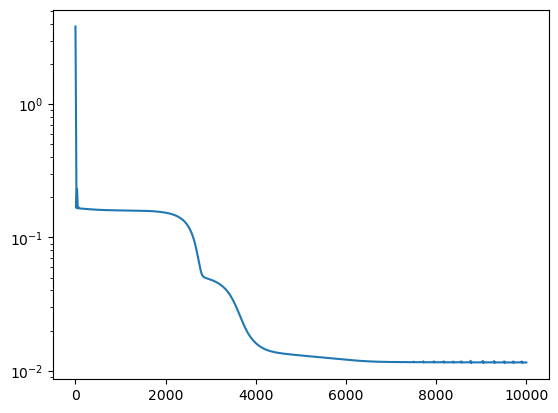

In [426]:
plt.plot(m.train_loss_history)
plt.yscale("log")

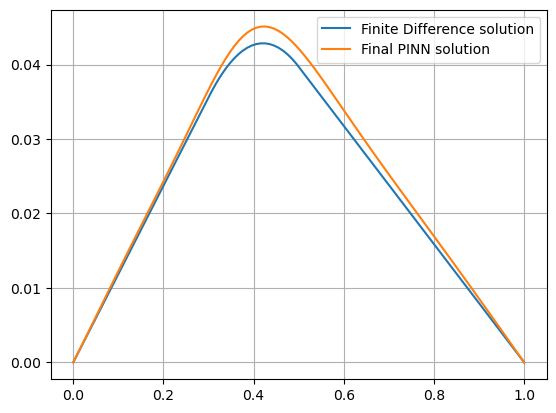

In [427]:
plt.plot(mesh_full, wrap_bc(finite_difference_solution), label="Finite Difference solution")
plt.plot(mesh_full, jax.vmap(pinn)(mesh_full), label="Final PINN solution")
plt.legend()
plt.grid()

In [428]:
m.score(mesh_full, wrap_bc(finite_difference_solution))

0.9889949231786035